# Figures for three scenarios

In [1]:
import numpy as np
import pickle
import csv
from matplotlib import pyplot as plt

In [9]:
with open('PKL_files/country_airport.pkl', 'rb') as file: # country region dict
    C_R = pickle.load(file)
for c in C_R:
    C_R[c] = sorted(C_R[c])

In [69]:
covid_path = '/Program_data/Apt_pandemic_init_data.csv'
travel_path =  '/Program_data/region_air_passenger.csv'
vac_path = '/Program_data/Country_vaccine.csv'


N_p = {} #the dict to store population data {area code: population}
N_0 = {}  # the dict to store the initial health state data {area code: [S,V, L, I_a, I_t, I_nt, R]}
with open(covid_path, newline='') as covid_f:
    covid_reader = csv.reader(covid_f, delimiter= ' ', quotechar='|')
    next(covid_reader, None)
    for row in covid_reader:
        (c_code, r_code, a_code, a_name, t_pop, S, V, L, I, R)=row[0].split(',')
        N_p[int(a_code)] = int(t_pop)
        N_0[int(a_code)]= [float(S),float(V), float(L),float(I),float(R)]       


X = {} #the dict to store travel data {(date, dep, arr): passenger count}
with open(travel_path, newline='') as travel_f:
    travel_reader = csv.reader(travel_f, delimiter= ' ', quotechar='|')
    next(travel_reader, None)
    for row in travel_reader:
        (dep, arr,d_apt, a_apt, d_cou, a_cou, pcnt)=row[0].split(',')
        #print(dep, arr)
        X[(int(dep), int(arr))] = float(pcnt)
# make the transport matrix symmetric 
X_new = {}
for l in X.keys():
    if (l[1], l[0]) not in X:
        X_new[(l[1], l[0])] = X[l]
X.update(X_new)
for l in X:
    if X[l] > X[(l[1], l[0])]:
        X[(l[1], l[0])] = X[l]

# get the international air mobility between countries
air_int = {c1:{c2:0 for c2 in C_R if c2 != c1} for c1 in C_R}
for c1 in air_int:
    for c2 in air_int[c1]:
        for i in C_R[c1]:
            for j in C_R[c2]:
                if (i,j) in X:
                    air_int[c1][c2] += X[(i,j)]
        
country_vac = {} #the dict to store the real covid data, the active infective is a sum of 7 day increase
with open(vac_path, newline='') as vac_f:
    vac_reader = csv.reader(vac_f, delimiter= ' ', quotechar='|')
    next(vac_reader, None)
    for row in vac_reader:
        list_vac=row[0].split(',')
        country_vac[int(list_vac[0])] = [float(n) for n in list_vac[1:]]

In [18]:
covid_his_path = 'Program_data/country_his_infection.csv'

covid_his = {} #the dict to store the real covid data, the active infective is a sum of 7 day increase
with open(covid_his_path, newline='') as cov_f:
    cov_reader = csv.reader(cov_f, delimiter= ' ', quotechar='|')
    next(cov_reader, None)
    for row in cov_reader:
        list_cov=row[0].split(',')
        covid_his[int(list_cov[0])] = [int(n) for n in list_cov[2:]]
        
covid_his_period = {c:[] for c in C_R}
for c in C_R:
    for b in range(26):
        covid_his_period[c].append(sum(covid_his[c][b*7:(b+1)*7])/7)

In [7]:
with open('PKL_files/no_air_country_pair.pkl', 'rb') as file: # country pairs without direct air transport conection
    no_air_country_pair = pickle.load(file)

country_name = ['AU', 'BN', 'CN', 'ID', 'IN', 'JP', 'KH', 'KR', 'LA', 'MM', 'MY', 'NZ', 'PH', 'SG', 'TH', 'VN']

In [12]:
# color for plotting different countries
colors = plt.get_cmap('tab20').colors[:16]

## TOC scenario

In [38]:
with open('PKL_files/TOC_t_control(adjusted).pkl', 'rb') as file:
    toc_t_a = pickle.load(file)
    
with open('PKL_files/TOC_t_control(unadjusted).pkl', 'rb') as file:
    toc_t_u = pickle.load(file)
    
with open('PKL_files/TOC_epidemic_weekly.pkl', 'rb') as file:
    toc_ep = pickle.load(file)


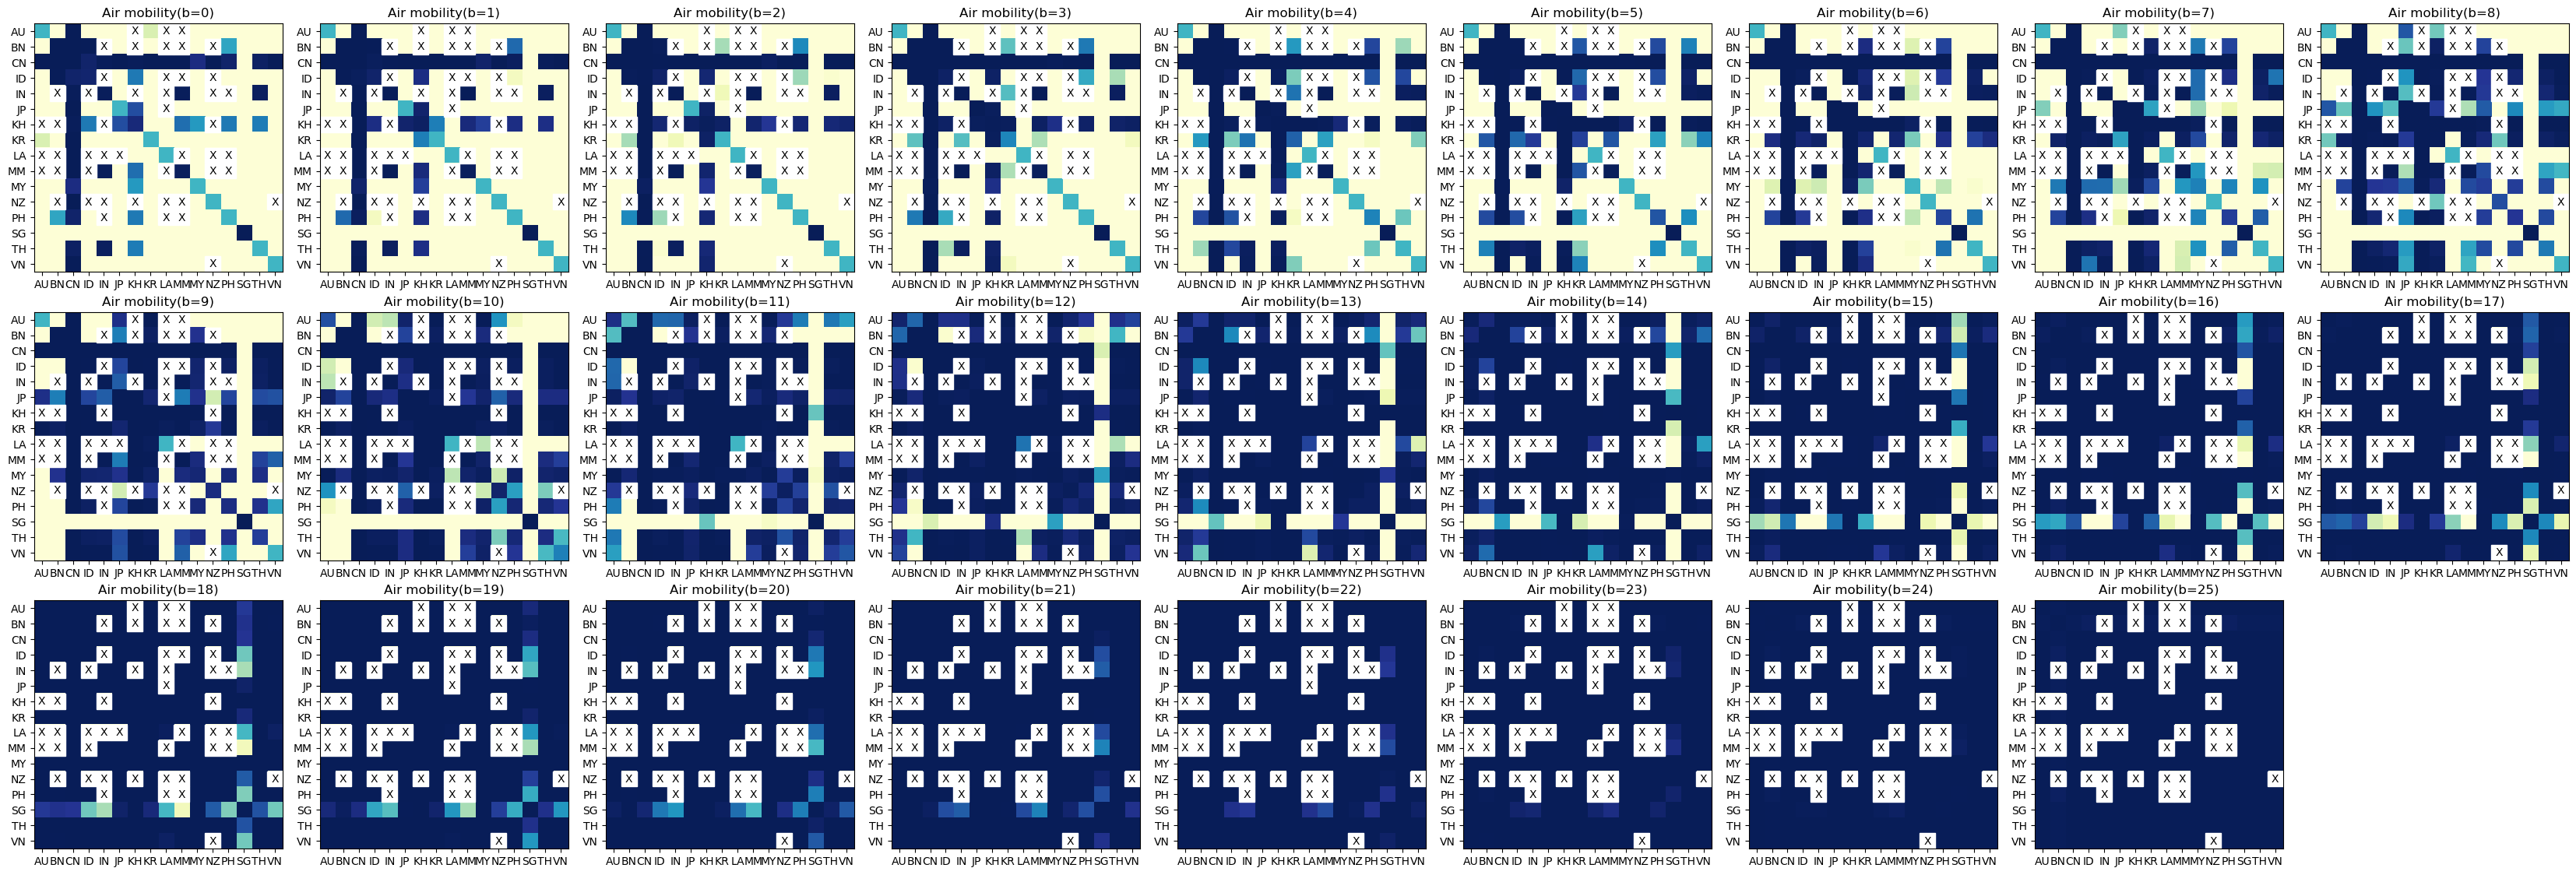

In [39]:
plt.figure(figsize=(42,14))
for b in vtc_t_a:
    plt.subplot(3,9,b+1)
# plot the control map
    plt.imshow(toc_t_a[b], cmap='YlGnBu', interpolation='nearest')
    #plt.colorbar()  
    plt.title('Air mobility(b={0})'.format(b))
    plt.xticks(range(16), country_name)
    plt.yticks(range(16), country_name)
    for (i, j) in no_air_country_pair:
        plt.fill([j-0.5, j+0.5, j+0.5, j-0.5], [i-0.5, i-0.5, i+0.5, i+0.5], color='white')
        plt.text(j, i, 'X', ha='center', va='center', color='black')
plt.subplots_adjust(hspace=0.1, wspace=0.15)
plt.show()

### Air mobility trends

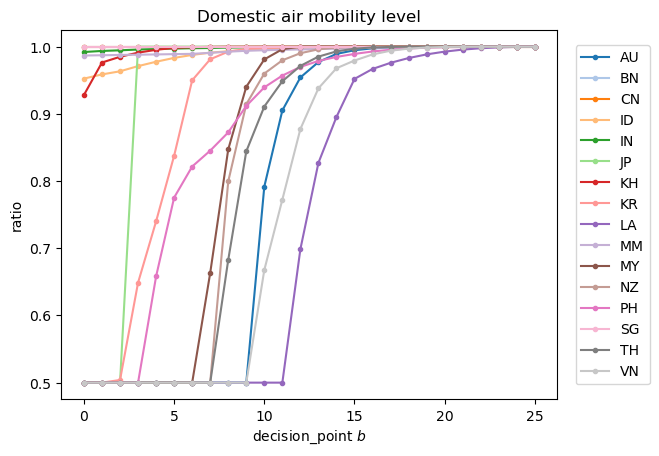

In [40]:
# domestic air mobility
TOC_air_dom = {}
for c in C_R:
    TOC_air_dom[c] = []
    X_dom_c = sum(X[l] for l in X if l[0] in C_R[c] and l[1] in C_R[c])
    for b in toc_t_a:
        TOC_air_dom[c].append(toc_t_a[b][(c,c)]*X_dom_c)
        
        
TOC_air_dom_ratio = {c:[toc_t_a[b][(c,c)] for b in toc_t_a] for c in C_R}

for c in TOC_air_dom_ratio:
    plt.plot(TOC_air_dom_ratio[c], color= colors[c], label=country_name[c], marker = '.')
plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5))
plt.title('Domestic air mobility level')
plt.ylabel('ratio')
plt.xlabel('decision_point $b$')
plt.show()

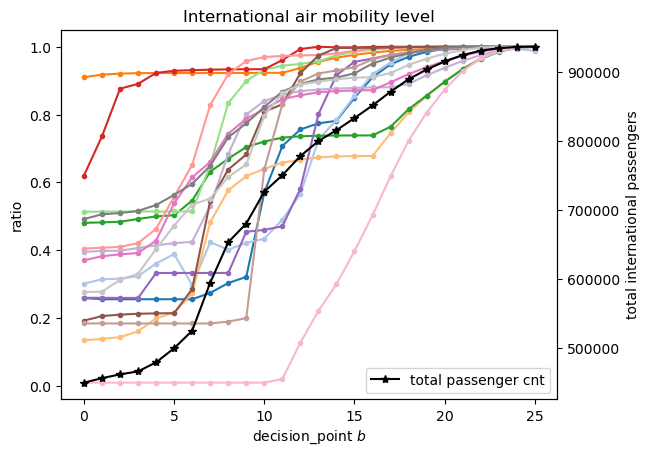

In [68]:
# international trends

TOC_air_int = {c:[0 for _ in range(26)] for c in C_R}
for b in toc_t_a:
    for c1 in air_int:
        for c2 in air_int[c1]:
            TOC_air_int[c1][b] += air_int[c1][c2]*toc_t_a[b][(c1,c2)]


TOC_air_int_control_total = [sum(TOC_air_int[c][j] for c in TOC_air_int) for j in range(26)]
TOC_air_int_control_ratio = {c: [TOC_air_int[c][j]/sum(air_int[c][c_c] for c_c in air_int[c]) for j in range(26)] for c in C_R}



fig, ax1 = plt.subplots()
for c in TOC_air_int_control_ratio:
    ax1.plot(TOC_air_int_control_ratio[c], color= colors[c], marker = '.')
ax1.set_ylabel('ratio')
ax1.set_xlabel('decision_point $b$')

ax2 = ax1.twinx()
ax2.plot(TOC_air_int_control_total, color = 'black', marker='*', linewidth = 1.5, label='total passenger cnt')
ax2.set_ylabel('total international passengers')

fig.legend(loc='right', bbox_to_anchor=(0.9, 0.15))
plt.title('International air mobility level')
plt.show()

### Infection trends

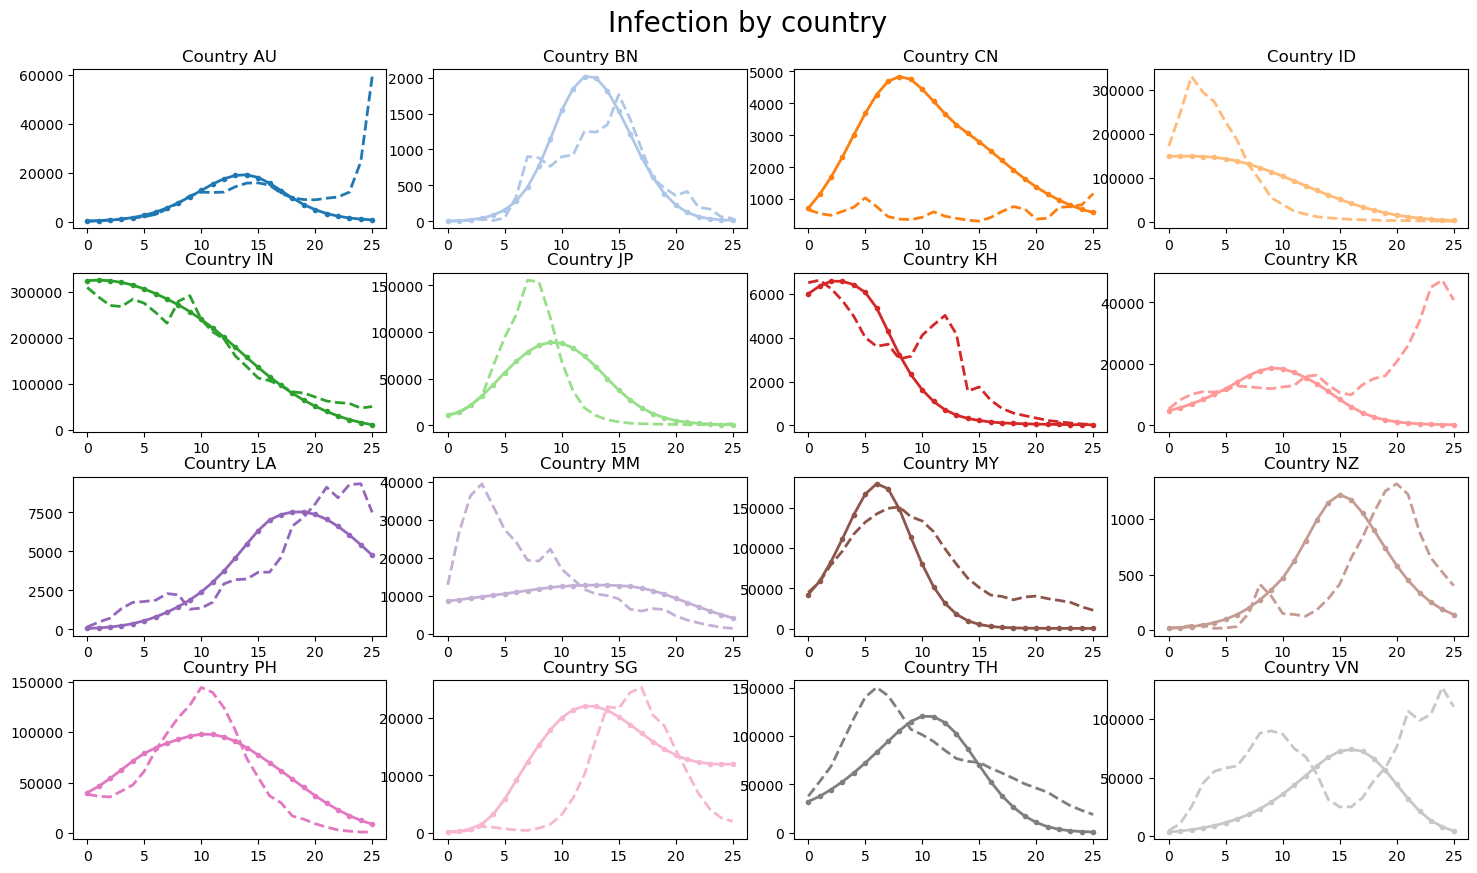

In [42]:
TOC_inf_country = {c:[sum(N_0[j][3] for j in C_R[c])] for c in C_R}
for b in range(1,26):
    for c in C_R:
        TOC_inf_country[c].append(sum(toc_ep[b][j][3] for j in C_R[c]))

        
plt.figure(figsize=(18,10))

for c in TOC_inf_country:
    plt.subplot(4,4,c+1)
    plt.plot(TOC_inf_country[c], color= colors[c], linewidth = 2, marker = '.')
    plt.plot(covid_his_period[c], color= colors[c], linewidth = 2, linestyle='--')
    plt.title('Country {0}'.format(country_name[c]))
plt.subplots_adjust(hspace=0.28, wspace=0.15)
plt.suptitle('Infection by country', fontsize =20, y = 0.94)
plt.show()

## VTC scenario

In [2]:
# load VTC files 

with open('PKL_files/VTC_t_control(adjusted).pkl', 'rb') as file:
    vtc_t_a = pickle.load(file)
    
with open('PKL_files/VTC_t_control(unadjusted).pkl', 'rb') as file:
    vtc_t_u = pickle.load(file)
    
with open('PKL_files/VTC_epidemic_weekly.pkl', 'rb') as file:
    vtc_ep = pickle.load(file)

with open('PKL_files/VTC_v_control.pkl', 'rb') as file:
    vtc_v = pickle.load(file)

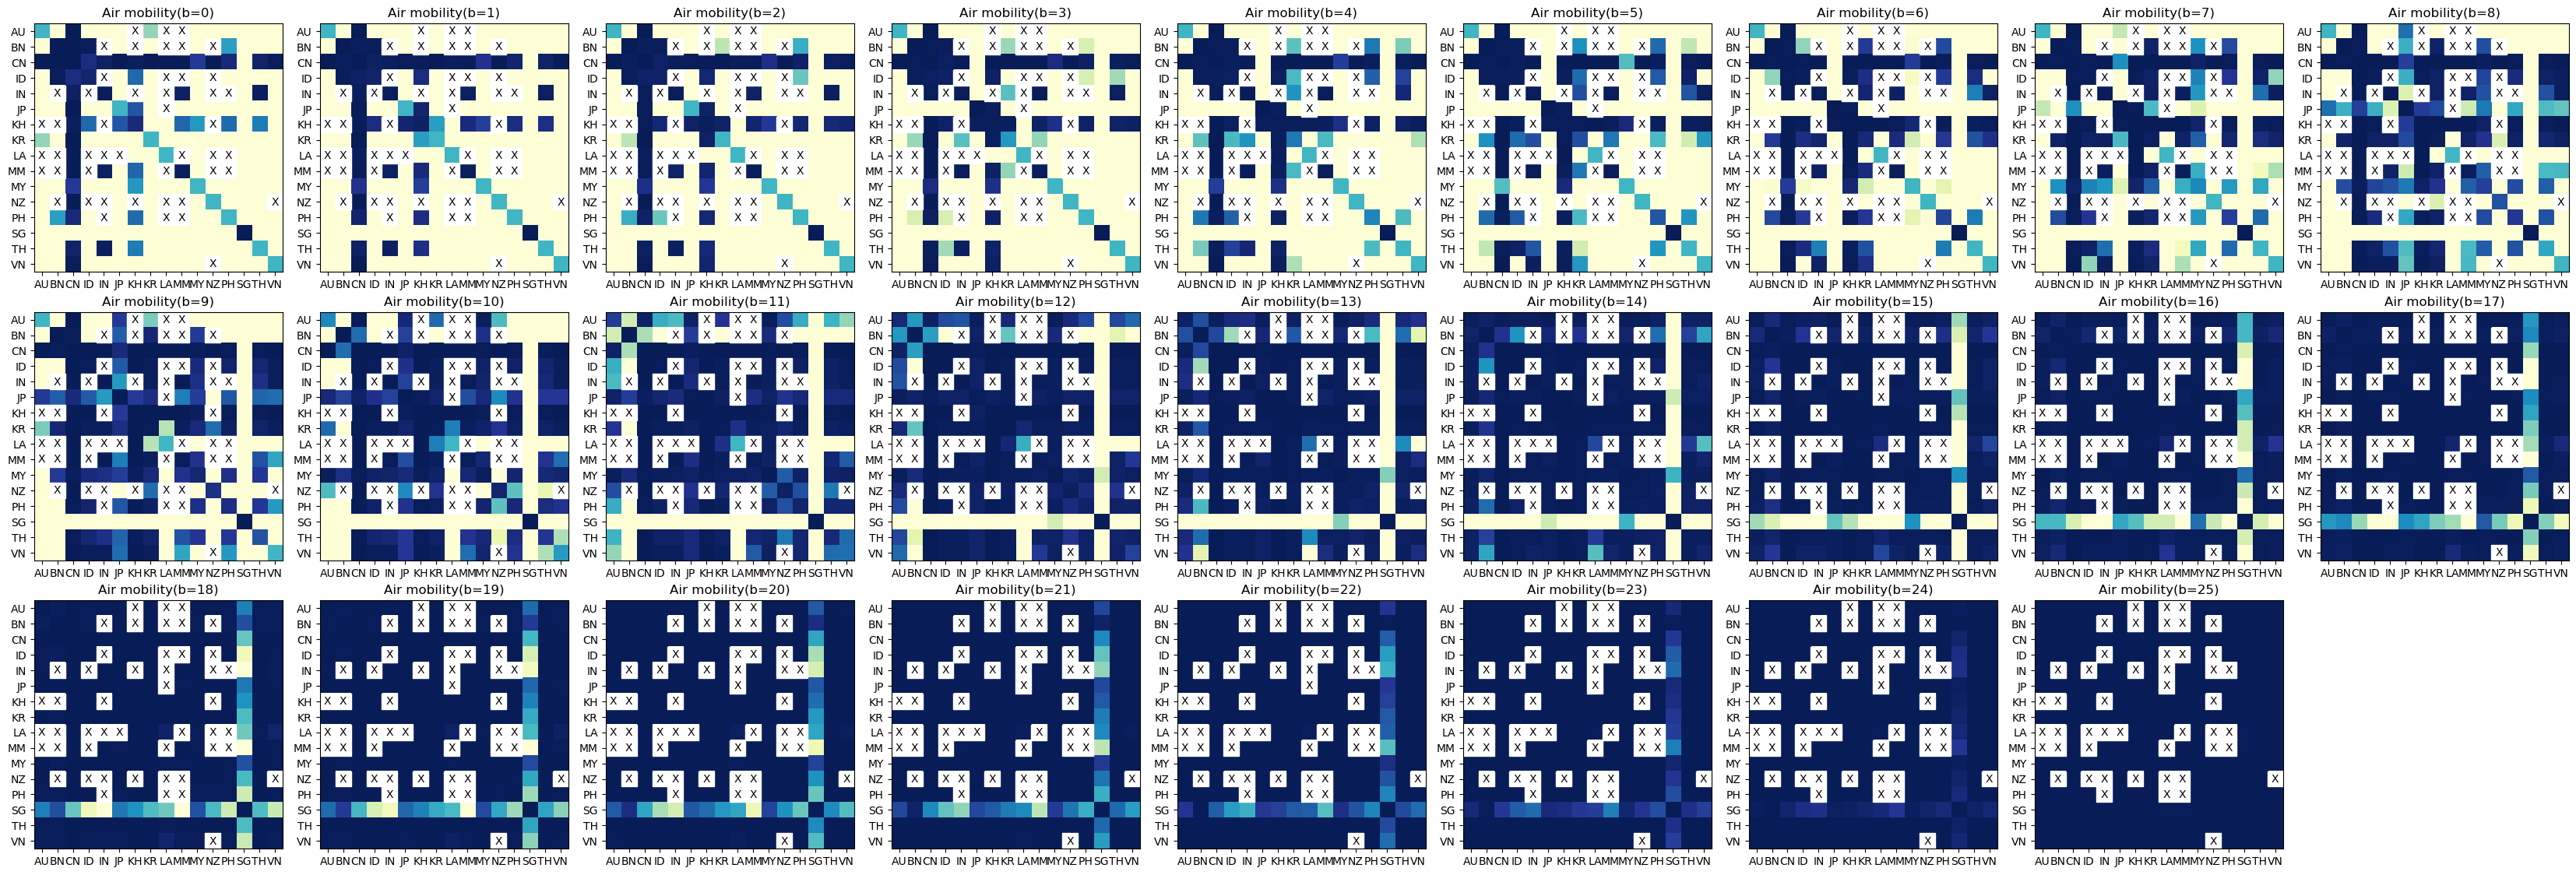

In [8]:
plt.figure(figsize=(42,14))
for b in vtc_t_a:
    plt.subplot(3,9,b+1)
# plot the control map
    plt.imshow(vtc_t_a[b], cmap='YlGnBu', interpolation='nearest')
    #plt.colorbar()  
    plt.title('Air mobility(b={0})'.format(b))
    plt.xticks(range(16), country_name)
    plt.yticks(range(16), country_name)
    for (i, j) in no_air_country_pair:
        plt.fill([j-0.5, j+0.5, j+0.5, j-0.5], [i-0.5, i-0.5, i+0.5, i+0.5], color='white')
        plt.text(j, i, 'X', ha='center', va='center', color='black')
plt.subplots_adjust(hspace=0.1, wspace=0.15)
plt.show()

### Air mobility trends

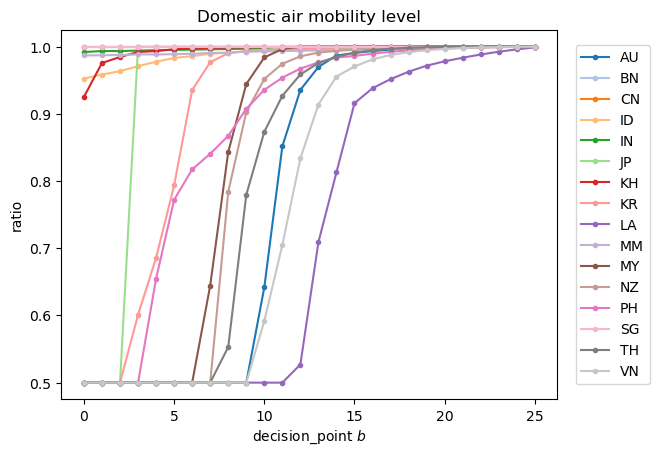

In [24]:
# domestic air mobility
VTC_air_dom = {}
for c in C_R:
    VTC_air_dom[c] = []
    X_dom_c = sum(X[l] for l in X if l[0] in C_R[c] and l[1] in C_R[c])
    for b in vtc_t_a:
        VTC_air_dom[c].append(vtc_t_a[b][(c,c)]*X_dom_c)
        
        
VTC_air_dom_ratio = {c:[vtc_t_a[b][(c,c)] for b in vtc_t_a] for c in C_R}

for c in VTC_air_dom_ratio:
    plt.plot(VTC_air_dom_ratio[c], color= colors[c], label=country_name[c], marker = '.')
plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5))
plt.title('Domestic air mobility level')
plt.ylabel('ratio')
plt.xlabel('decision_point $b$')
plt.show()

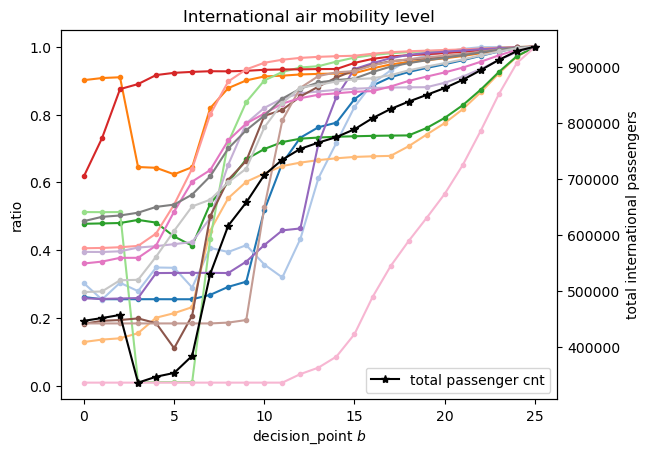

In [67]:
# international trends
        

VTC_air_int = {c:[0 for _ in range(26)] for c in C_R}
for b in vtc_t_a:
    for c1 in air_int:
        for c2 in air_int[c1]:
            VTC_air_int[c1][b] += air_int[c1][c2]*vtc_t_a[b][(c1,c2)]
         
        
        
VTC_air_int_control_total = [sum(VTC_air_int[c][j] for c in VTC_air_int) for j in range(26)]
VTC_air_int_control_ratio = {c: [VTC_air_int[c][j]/sum(air_int[c][c_c] for c_c in air_int[c]) for j in range(26)] for c in C_R}



fig, ax1 = plt.subplots()
for c in VTC_air_int_control_ratio:
    ax1.plot(VTC_air_int_control_ratio[c], color= colors[c], marker = '.')
ax1.set_ylabel('ratio')
ax1.set_xlabel('decision_point $b$')

ax2 = ax1.twinx()
ax2.plot(VTC_air_int_control_total, color = 'black', marker='*', linewidth = 1.5, label='total passenger cnt')
ax2.set_ylabel('total international passengers')

fig.legend(loc='right', bbox_to_anchor=(0.9, 0.15))
plt.title('International air mobility level')
plt.show()

### Infection trends

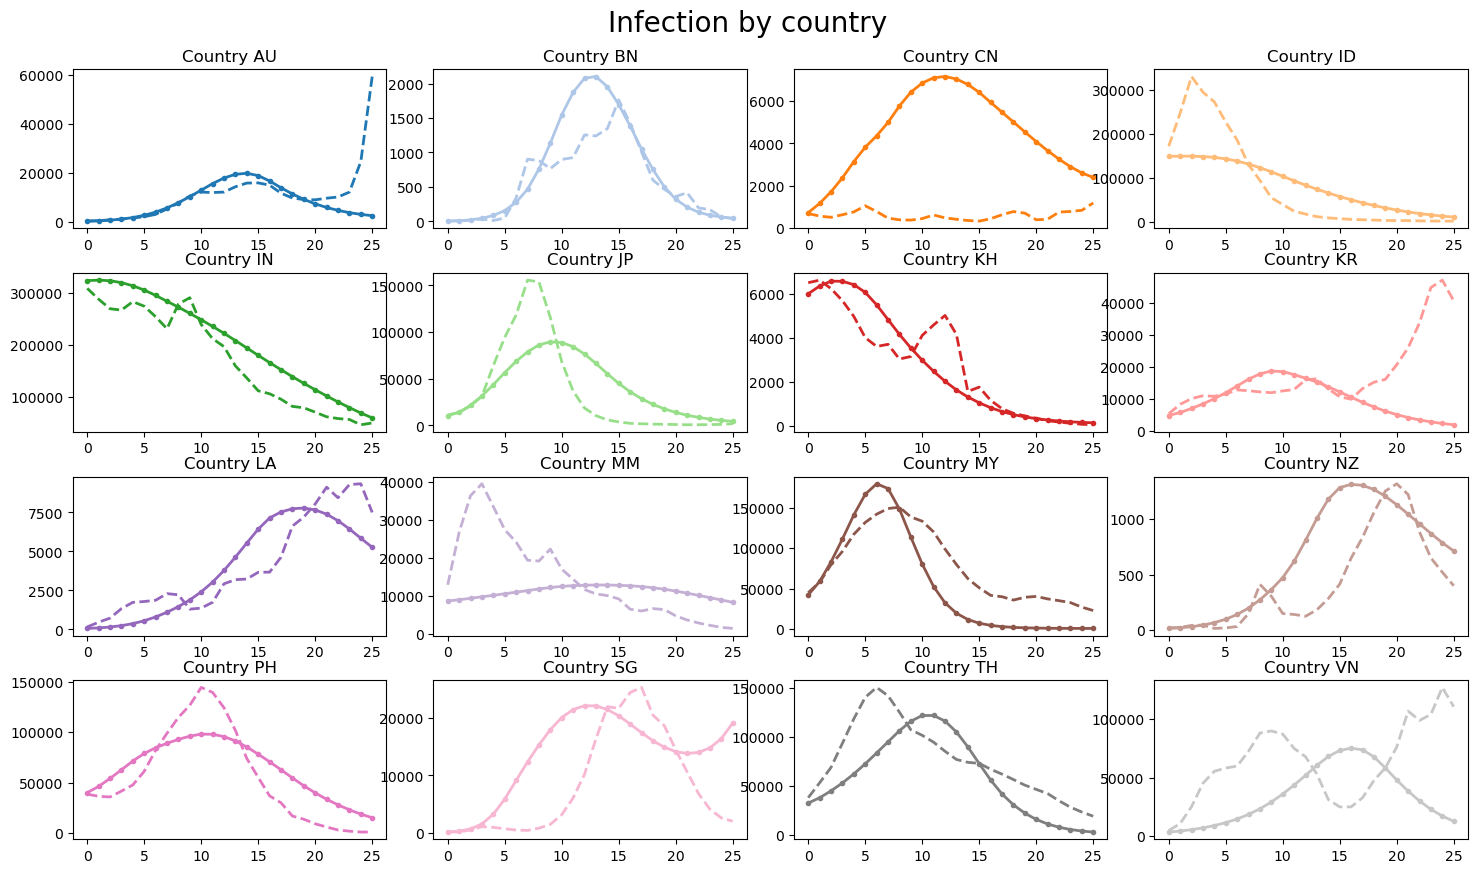

In [21]:
VTC_inf_country = {c:[sum(N_0[j][3] for j in C_R[c])] for c in C_R}
for b in range(1,26):
    for c in C_R:
        VTC_inf_country[c].append(sum(vtc_ep[b][j][3] for j in C_R[c]))
        

        
plt.figure(figsize=(18,10))

for c in VTC_inf_country:
    plt.subplot(4,4,c+1)
    plt.plot(VTC_inf_country[c], color= colors[c], linewidth = 2, marker = '.')
    plt.plot(covid_his_period[c], color= colors[c], linewidth = 2, linestyle='--')
    plt.title('Country {0}'.format(country_name[c]))
plt.subplots_adjust(hspace=0.28, wspace=0.15)
plt.suptitle('Infection by country', fontsize =20, y = 0.94)
plt.show()

### Vaccine usage

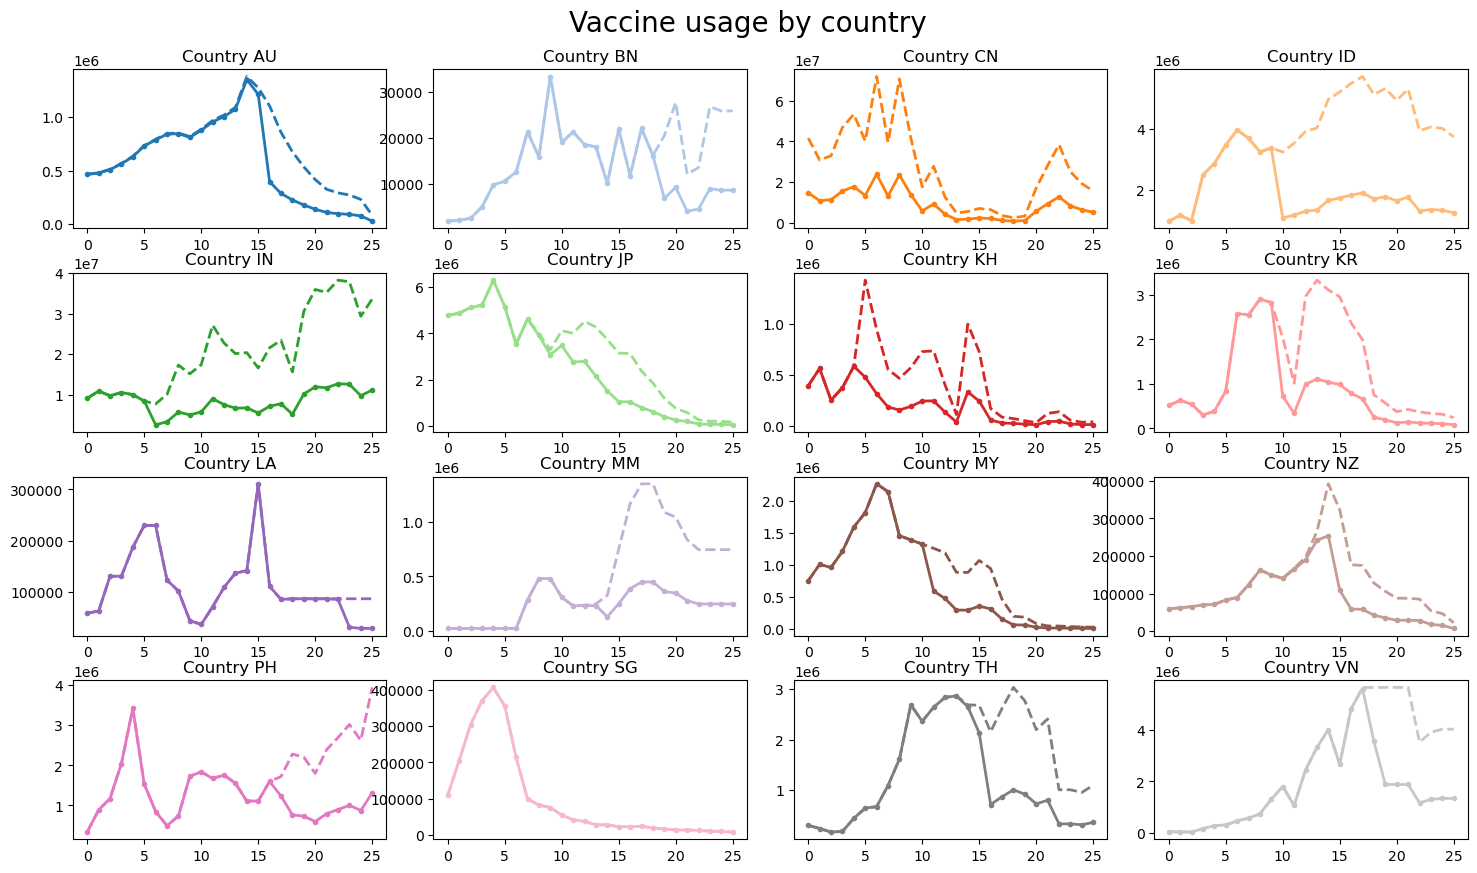

In [36]:
VTC_V_con_sum = {c:[] for c in C_R}
V_his_sum = {c:[] for c in C_R}
for b in range(26):
    for c in C_R:
        VTC_V_con_sum[c].append(sum(vtc_ep[b][j][0]*vtc_v[b][j]*7 for j in C_R[c])) 
        V_his_sum[c].append(sum(country_vac[c][b*7:(b+1)*7]))
        
        
plt.figure(figsize=(18,10))

for c in VTC_V_con_sum:
    plt.subplot(4,4,c+1)
    plt.plot(VTC_V_con_sum[c], color= colors[c], linewidth = 2, marker = '.')
    plt.plot(V_his_sum[c], color= colors[c], linewidth = 2, linestyle='--')
    plt.title('Country {0}'.format(country_name[c]))
plt.subplots_adjust(hspace=0.28, wspace=0.15)
plt.suptitle('Vaccine usage by country', fontsize =20, y = 0.94)
plt.show()

## VTC-S scenario

In [22]:
# load VTC-S files 

with open('PKL_files/VTC-S_t_control(adjusted).pkl', 'rb') as file:
    vtc_s_t_a = pickle.load(file)
    
with open('PKL_files/VTC-S_t_control(unadjusted).pkl', 'rb') as file:
    vtc_s_t_u = pickle.load(file)
    
with open('PKL_files/VTC-S_epidemic_weekly.pkl', 'rb') as file:
    vtc_s_ep = pickle.load(file)

with open('PKL_files/VTC-S_v_control.pkl', 'rb') as file:
    vtc_s_v = pickle.load(file)

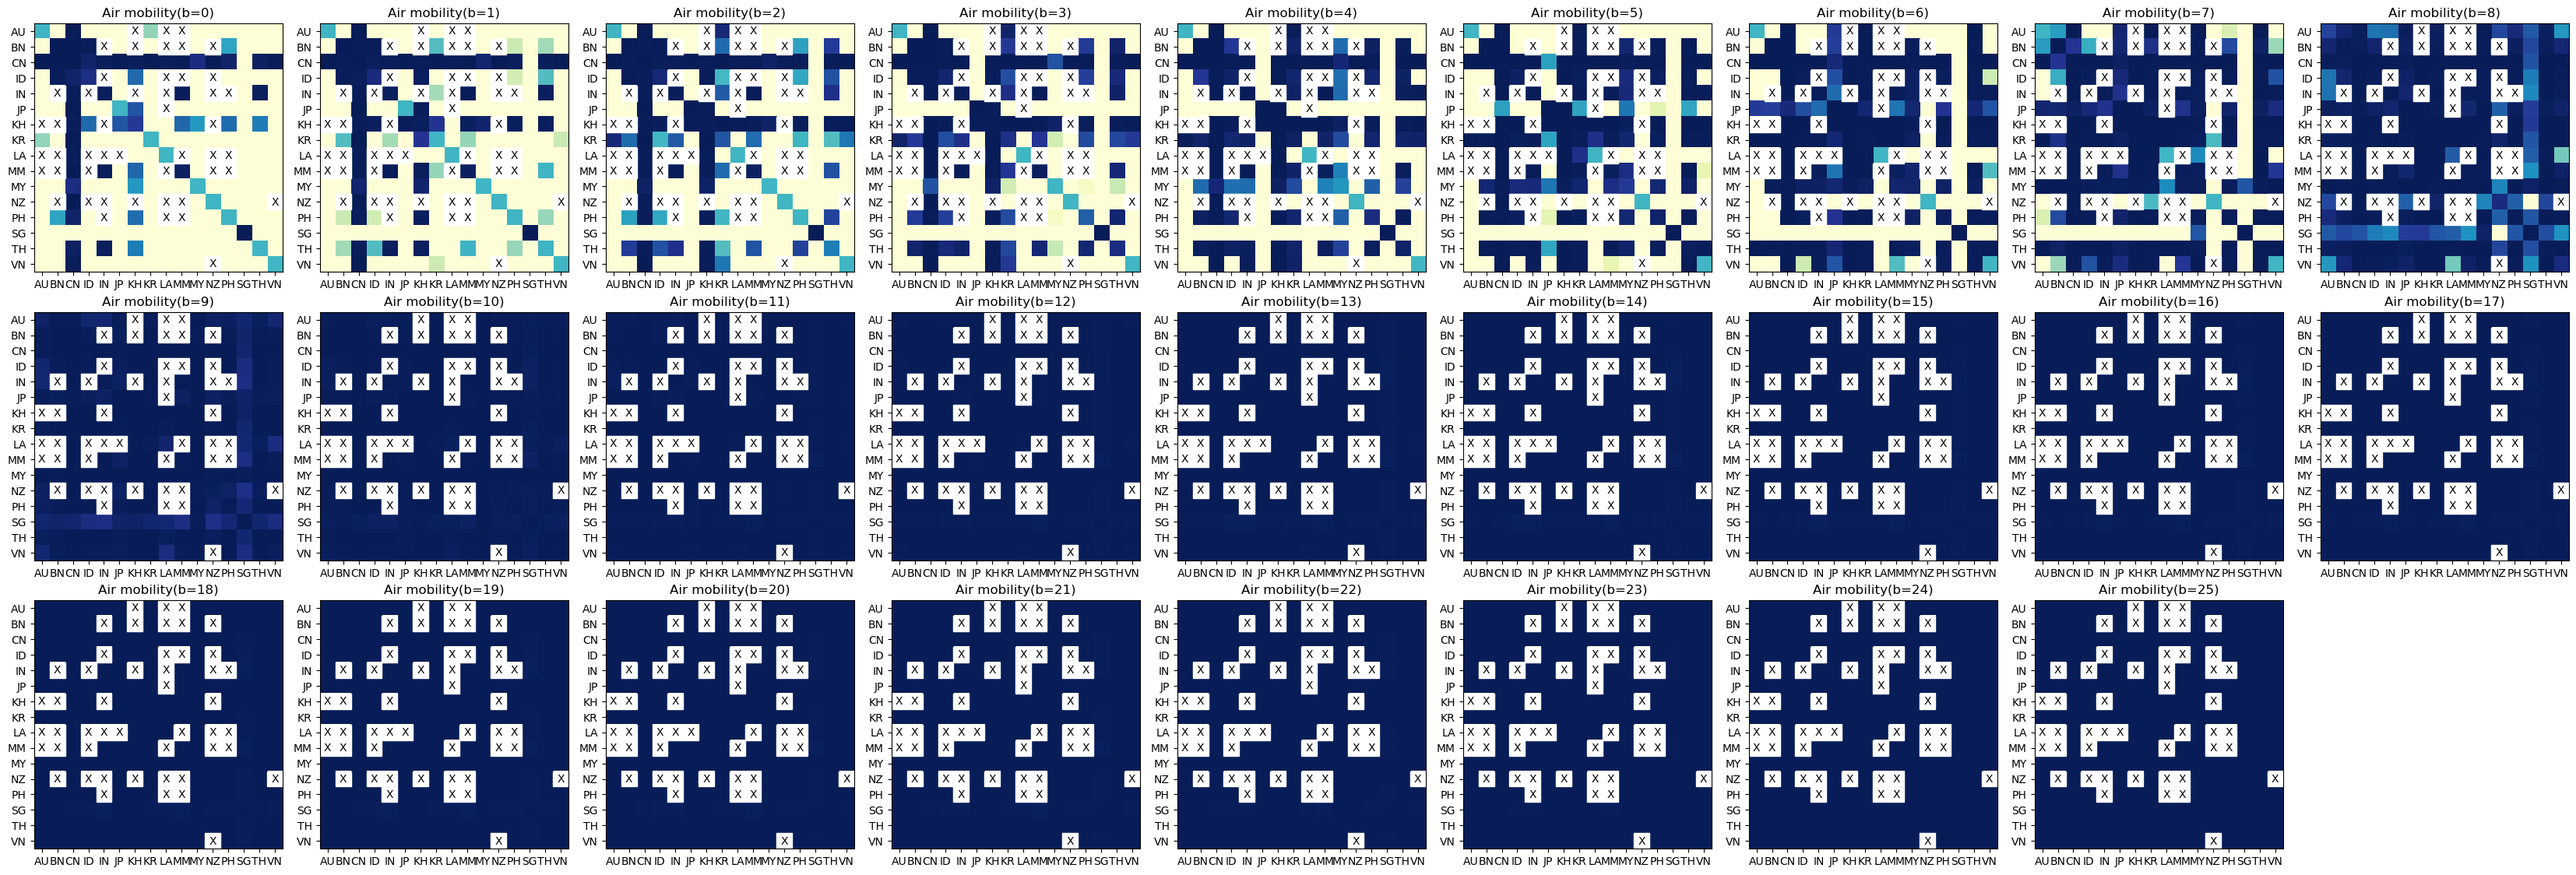

In [23]:
plt.figure(figsize=(42,14))
for b in vtc_s_t_a:
    plt.subplot(3,9,b+1)
# plot the control map
    plt.imshow(vtc_s_t_a[b], cmap='YlGnBu', interpolation='nearest')
    #plt.colorbar()  
    plt.title('Air mobility(b={0})'.format(b))
    plt.xticks(range(16), country_name)
    plt.yticks(range(16), country_name)
    for (i, j) in no_air_country_pair:
        plt.fill([j-0.5, j+0.5, j+0.5, j-0.5], [i-0.5, i-0.5, i+0.5, i+0.5], color='white')
        plt.text(j, i, 'X', ha='center', va='center', color='black')
plt.subplots_adjust(hspace=0.1, wspace=0.15)
plt.show()

### Air mobility trend chart

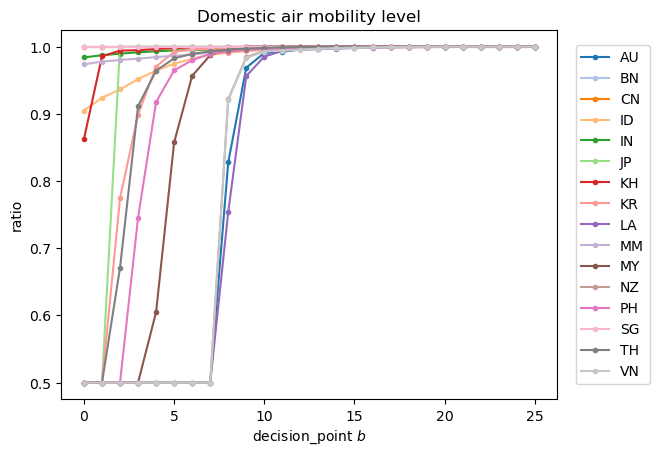

In [25]:
VTC_S_air_dom = {}
for c in C_R:
    VTC_S_air_dom[c] = []
    X_dom_c = sum(X[l] for l in X if l[0] in C_R[c] and l[1] in C_R[c])
    for b in vtc_s_t_a:
        VTC_S_air_dom[c].append(vtc_s_t_a[b][(c,c)]*X_dom_c)
        
        
VTC_S_air_dom_ratio = {c:[vtc_s_t_a[b][(c,c)] for b in vtc_s_t_a] for c in C_R}

for c in VTC_S_air_dom_ratio:
    plt.plot(VTC_S_air_dom_ratio[c], color= colors[c], label=country_name[c], marker = '.')
plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5))
plt.title('Domestic air mobility level')
plt.ylabel('ratio')
plt.xlabel('decision_point $b$')
plt.show()

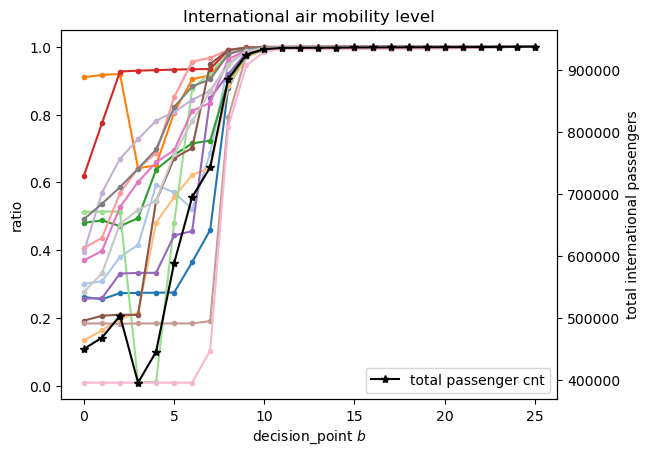

In [66]:
# international trends
       

VTC_S_air_int = {c:[0 for _ in range(26)] for c in C_R}
for b in vtc_s_t_a:
    for c1 in air_int:
        for c2 in air_int[c1]:
            VTC_S_air_int[c1][b] += air_int[c1][c2]*vtc_s_t_a[b][(c1,c2)]
         
        
        
VTC_S_air_int_control_total = [sum(VTC_S_air_int[c][j] for c in VTC_S_air_int) for j in range(26)]
VTC_S_air_int_control_ratio = {c: [VTC_S_air_int[c][j]/sum(air_int[c][c_c] for c_c in air_int[c]) for j in range(26)] for c in C_R}



fig, ax1 = plt.subplots()
for c in VTC_S_air_int_control_ratio:
    ax1.plot(VTC_S_air_int_control_ratio[c], color= colors[c], marker = '.')
ax1.set_ylabel('ratio')
ax1.set_xlabel('decision_point $b$')

ax2 = ax1.twinx()
ax2.plot(VTC_S_air_int_control_total, color = 'black', marker='*', linewidth = 1.5, label='total passenger cnt')
ax2.set_ylabel('total international passengers')

fig.legend(loc='right', bbox_to_anchor=(0.9, 0.15))
plt.title('International air mobility level')
plt.show()

### Infection trends

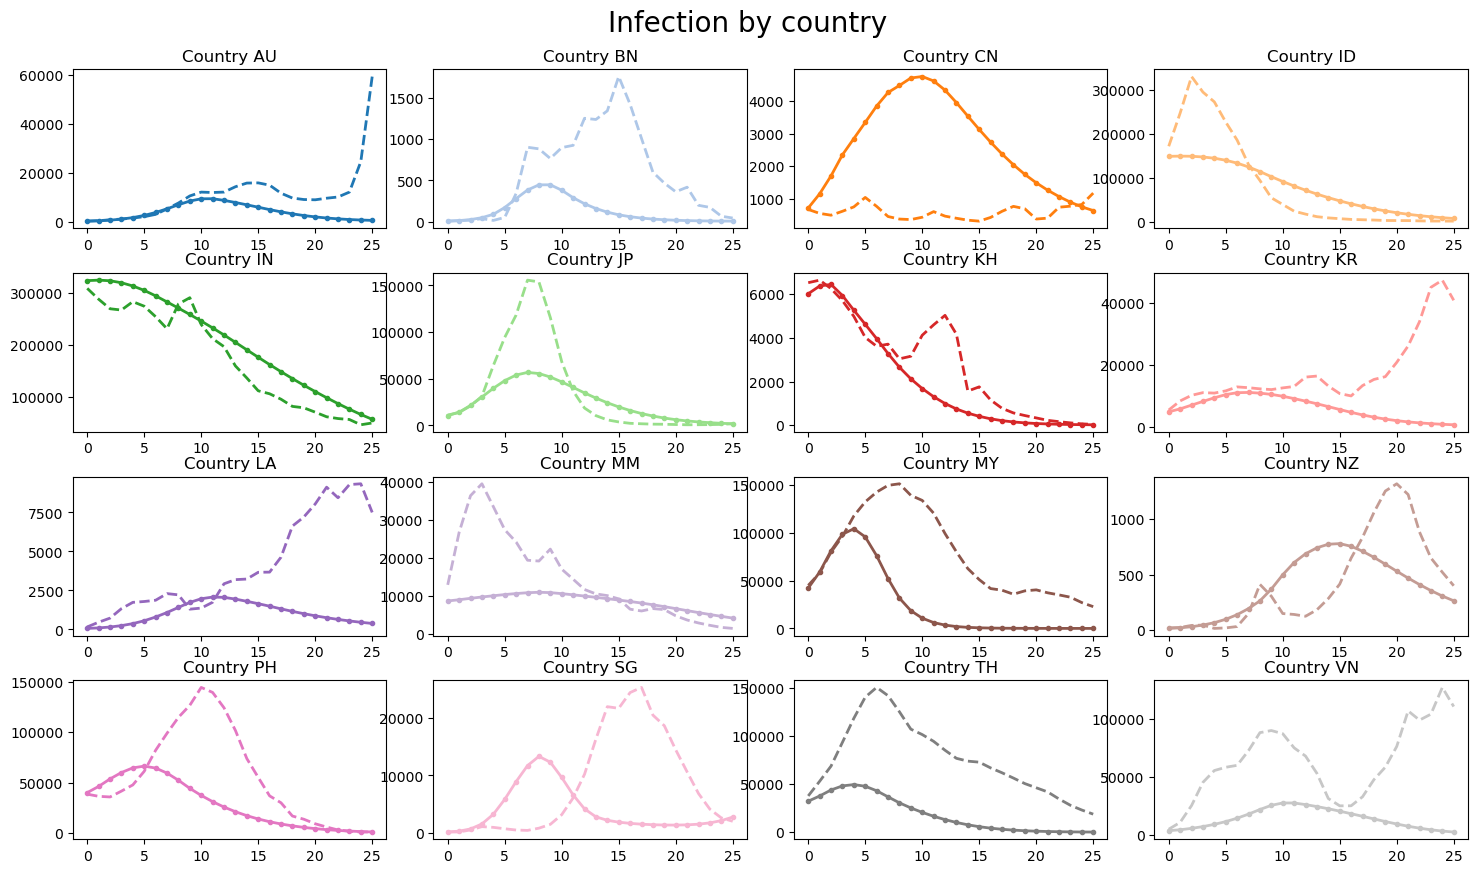

In [28]:
VTC_S_inf_country = {c:[sum(N_0[j][3] for j in C_R[c])] for c in C_R}
for b in range(1,26):
    for c in C_R:
        VTC_S_inf_country[c].append(sum(vtc_s_ep[b][j][3] for j in C_R[c]))
        

        
plt.figure(figsize=(18,10))

for c in VTC_S_inf_country:
    plt.subplot(4,4,c+1)
    plt.plot(VTC_S_inf_country[c], color= colors[c], linewidth = 2, marker = '.')
    plt.plot(covid_his_period[c], color= colors[c], linewidth = 2, linestyle='--')
    plt.title('Country {0}'.format(country_name[c]))
plt.subplots_adjust(hspace=0.28, wspace=0.15)
plt.suptitle('Infection by country', fontsize =20, y = 0.94)
plt.show()

### Vaccine usage

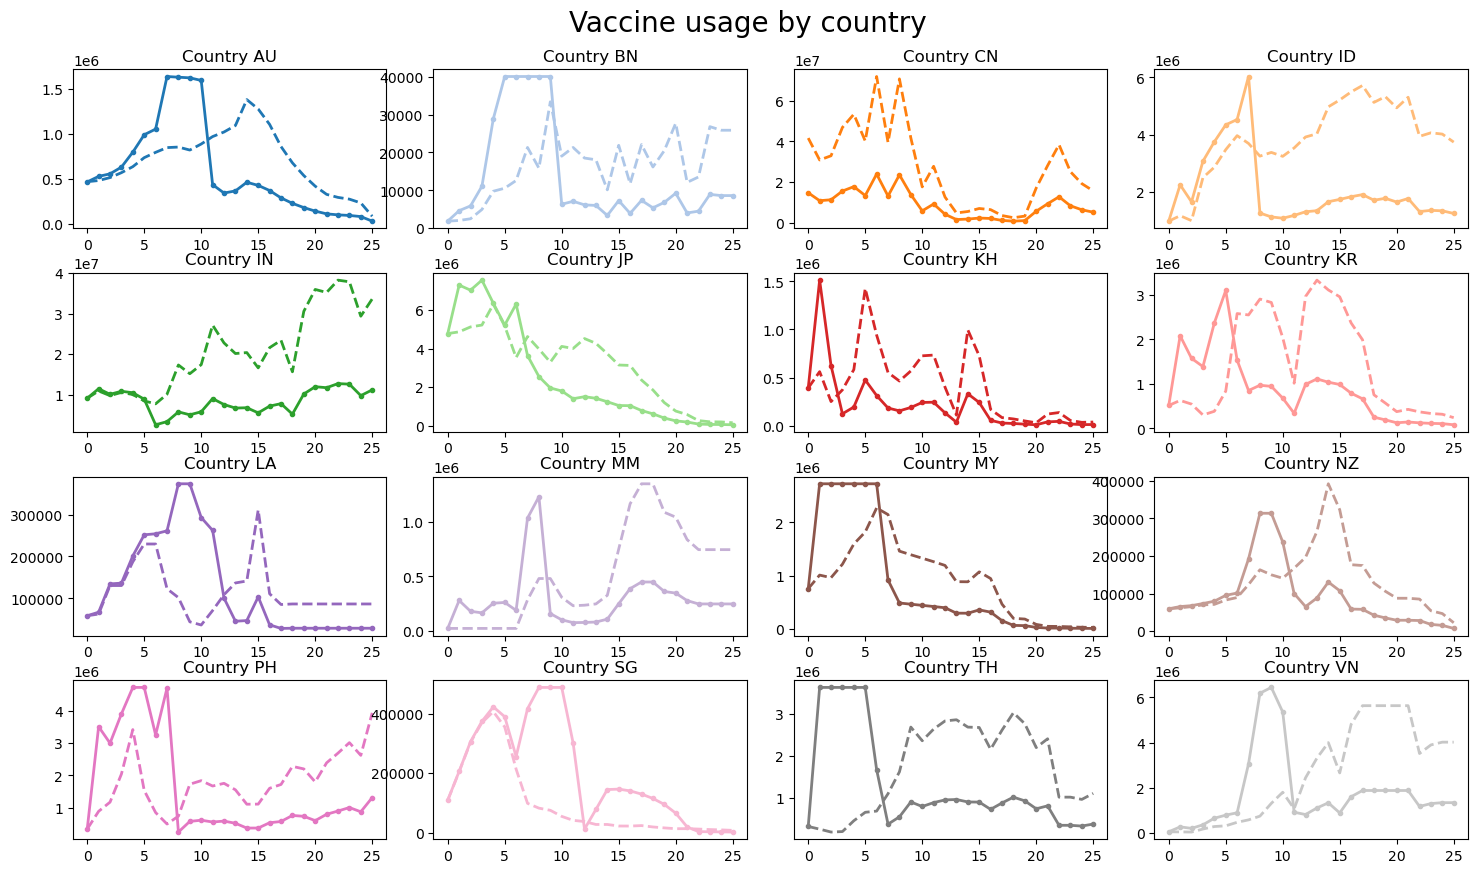

In [37]:
VTC_S_V_con_sum = {c:[] for c in C_R}
V_his_sum = {c:[] for c in C_R}
for b in range(26):
    for c in C_R:
        VTC_S_V_con_sum[c].append(sum(vtc_s_ep[b][j][0]*vtc_s_v[b][j]*7 for j in C_R[c])) 
        V_his_sum[c].append(sum(country_vac[c][b*7:(b+1)*7]))
        
        
plt.figure(figsize=(18,10))

for c in VTC_S_V_con_sum:
    plt.subplot(4,4,c+1)
    plt.plot(VTC_S_V_con_sum[c], color= colors[c], linewidth = 2, marker = '.')
    plt.plot(V_his_sum[c], color= colors[c], linewidth = 2, linestyle='--')
    plt.title('Country {0}'.format(country_name[c]))
plt.subplots_adjust(hspace=0.28, wspace=0.15)
plt.suptitle('Vaccine usage by country', fontsize =20, y = 0.94)
plt.show()

## Compare with real situation (transport)

### Real data

In [29]:
dom_real_path = '/Program_data/Domestic_Air_2021_real.csv'

Dom_real = {} #the dict to store the real covid data, the active infective is a sum of 7 day increase
with open(dom_real_path, newline='') as dom_f:
    dom_reader = csv.reader(dom_f, delimiter= ' ', quotechar='|')
    next(dom_reader, None)
    for row in dom_reader:
        list_dom = row[0].split(',')
        Dom_real[int(list_dom[0])] = [float(n) for n in list_dom[1:]]
        
int_real_path = '/Program_data/Int_Air_2021_real.csv'

Int_real = {} #the dict to store the real covid data, the active infective is a sum of 7 day increase
with open(int_real_path, newline='') as int_f:
    int_reader = csv.reader(int_f, delimiter= ' ', quotechar='|')
    next(int_reader, None)
    for row in int_reader:
        list_int = row[0].split(',')
        Int_real[(int(list_int[0]), int(list_int[1]))] = [float(n) for n in list_int[2:]]     

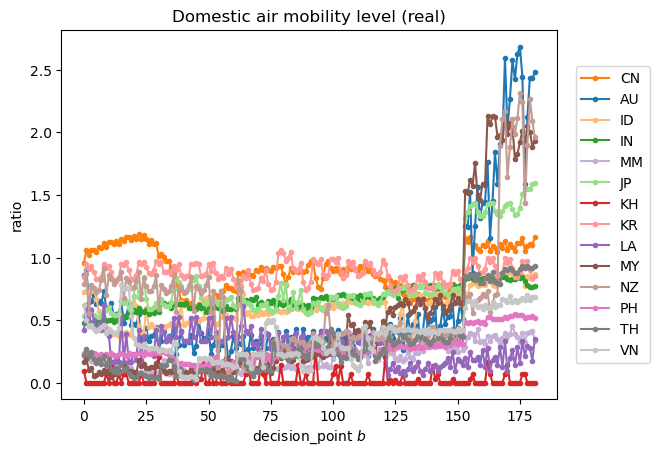

In [56]:
Dom_real_ratio = {c: [Dom_real[c][t]/sum(X[l] for l in X if l[0] in C_R[c] and l[1] in C_R[c]) for t in range(182)] for c in Dom_real}

colors = plt.get_cmap('tab20').colors[:16]

for c in Dom_real:
    plt.plot(Dom_real_ratio[c], color= colors[c], label=country_name[c], marker = '.')
plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5))
plt.title('Domestic air mobility level (real)')
plt.ylabel('ratio')
plt.xlabel('decision_point $b$')
plt.show()

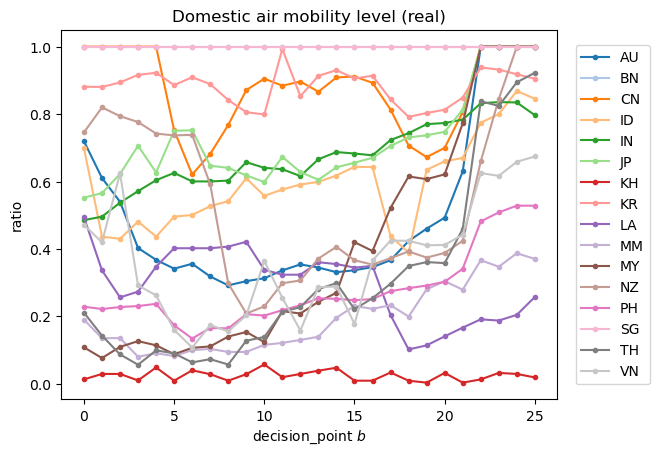

In [58]:
dom_ratio_adjusted = {c:[] for c in C_R}
for b in range(26):
    for c in Dom_real_ratio:
        ratio_c = sum(Dom_real_ratio[c][b*7:(b+1)*7])/7
        if ratio_c>1:
            dom_ratio_adjusted[c].append(1)
        else:
            dom_ratio_adjusted[c].append(ratio_c)
dom_ratio_adjusted[1] = [1]*26
dom_ratio_adjusted[13] = [1]*26

dom_ratio_adjusted

for c in dom_ratio_adjusted:
    plt.plot(dom_ratio_adjusted[c], color= colors[c], label=country_name[c], marker = '.')
plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5))
plt.title('Domestic air mobility level (real)')
plt.ylabel('ratio')
plt.xlabel('decision_point $b$')
plt.show()


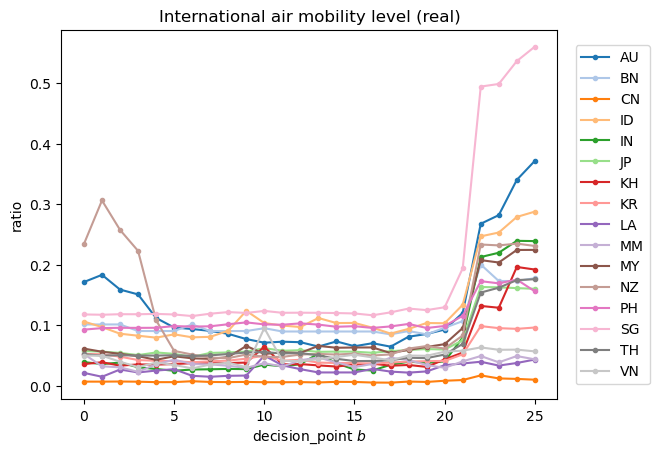

In [65]:
int_air_real_daily = {c: [sum(Int_real[l][t] for l in Int_real if l[1]==c) for t in range(182)] for c in C_R}
int_air_real = {c:[sum(int_air_real_daily[c][b*7: (b+1)*7])/7 for b in range(26)] for c in C_R}
air_int_real_ratio = {c: [int_air_real[c][b]/sum(air_int[c][c_c] for c_c in air_int[c]) for b in range(26)] for c in C_R}

for c in air_int_real_ratio:
    plt.plot(air_int_real_ratio[c], color= colors[c], label=country_name[c], marker = '.')
plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5))
plt.title('International air mobility level (real)')
plt.ylabel('ratio')
plt.xlabel('decision_point $b$')
plt.show()

### Real data compare to model output

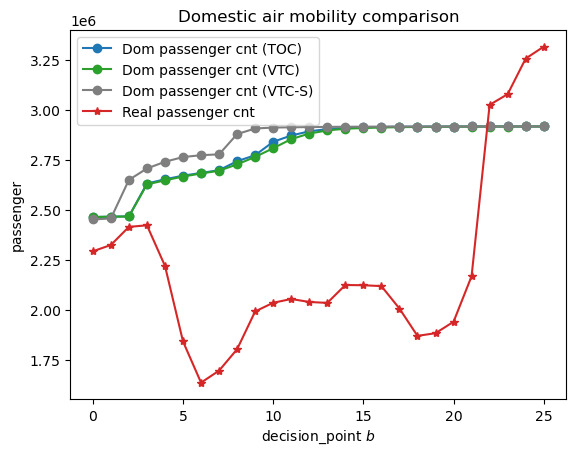

In [51]:
real__dom_sum_daily = [sum(Dom_real[c][t] for c in Dom_real) for t in range(182)]
real_dom_sum_b = [sum(real__dom_sum_daily[b*7:(b+1)*7])/7 for b in range(26)]

TOC_dom_sum = [sum(TOC_air_dom[c][b] for c in TOC_air_dom) for b in range(26)]
VTC_dom_sum = [sum(VTC_air_dom[c][b] for c in VTC_air_dom) for b in range(26)]
VTC_S_dom_sum = [sum(VTC_S_air_dom[c][b] for c in VTC_S_air_dom) for b in range(26)]


plt.plot(TOC_dom_sum,color = 'Tab:blue', marker='o', linewidth = 1.5, label='Dom passenger cnt (TOC)')
plt.plot(VTC_dom_sum,color = 'Tab:green', marker='o', linewidth = 1.5, label='Dom passenger cnt (VTC)')
plt.plot(VTC_S_dom_sum,color = 'Tab:grey', marker='o', linewidth = 1.5, label='Dom passenger cnt (VTC-S)')
plt.plot(real_dom_sum_b, color = 'Tab:red', marker='*', linewidth = 1.5, label='Real passenger cnt')
plt.legend()
plt.title('Domestic air mobility comparison')
plt.ylabel('passenger')
plt.xlabel('decision_point $b$')
plt.show()

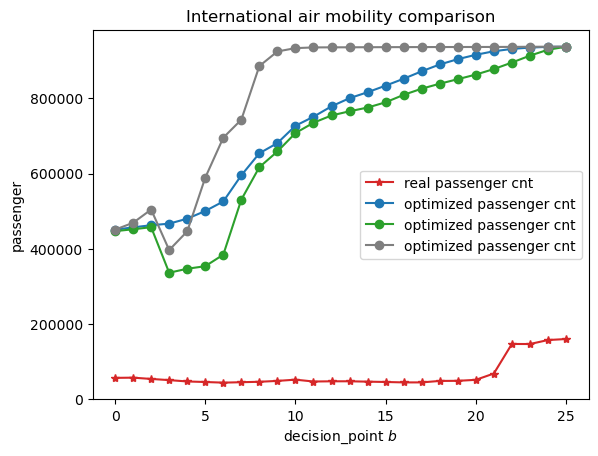

In [55]:
real_int_air_daily = {c: [sum(Int_real[l][t] for l in Int_real if l[1]==c) for t in range(182)] for c in C_R}
real_int_air = {c:[sum(real_int_air_daily[c][b*7: (b+1)*7])/7 for b in range(26)] for c in C_R}
real_int_air_sum = [sum(real_int_air[c][b] for c in C_R) for b in range(26)]

TOC_int_sum = [sum(TOC_air_int[c][b] for c in TOC_air_int) for b in range(26)]
VTC_int_sum = [sum(VTC_air_int[c][b] for c in VTC_air_int) for b in range(26)]
VTC_S_int_sum = [sum(VTC_S_air_int[c][b] for c in VTC_S_air_int) for b in range(26)]


plt.plot(int_air_real_total, color = 'Tab:red', marker='*', linewidth = 1.5, label='real passenger cnt')
plt.plot(TOC_int_sum, color = 'Tab:blue', marker='o', linewidth = 1.5, label='optimized passenger cnt')
plt.plot(VTC_int_sum, color = 'Tab:green', marker='o', linewidth = 1.5, label='optimized passenger cnt')
plt.plot(VTC_S_int_sum, color = 'Tab:grey', marker='o', linewidth = 1.5, label='optimized passenger cnt')
plt.title('International air mobility comparison')
plt.legend()
plt.ylabel('passenger')
plt.xlabel('decision_point $b$')
plt.show()